In [74]:
!jupyter nbconvert --to html StarForceSimulation.ipynb

[NbConvertApp] Converting notebook StarForceSimulation.ipynb to html
[NbConvertApp] Writing 1358313 bytes to StarForceSimulation.html


# Introduction

Many games, both digital and real, incorporate chance elements into their gameplay to add a levels of uncertainancy and mystery to their outcome.

In Maplestory, an infamous MMORPG, there is a system that allows certain items to be enhanced up to 25 stars, but the "cost" of enhancing an item from 12 to 22 stars, is not straightforward due to the random nature of the enhancement process. 

The outcome of an enhancement attempt can result in four different scenarios depending on the current enhancement level: success with increase in enhancement level, failure with no change in enhancement level, failure with a drop in enhancement level, or failure with destruction of the item.

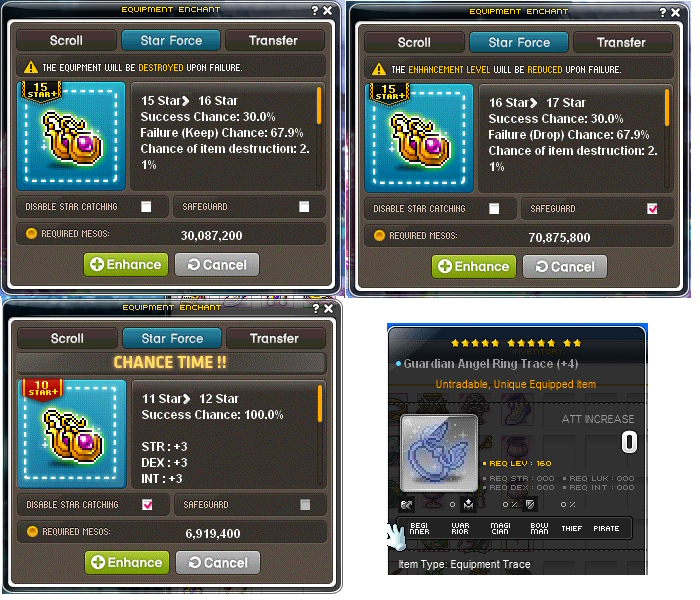

We can organize this system by dividing it into two components:

An array that stores the success probability for a given enhancement level,

And a two-dimensional array that holds the likelihood of the item being kept, dropped, or destroyed in the event of a failed attempt.


In [ ]:
SuccessRates = [0.95, 0.9, 0.85, 0.85, 0.80, 0.75, 0.70, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.3, 0.3, 0.3, 0.3,
             0.3, 0.3, 0.3, 0.03, 0.02, 0.01]

FailureRates = [[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0],
                [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0],
                [1, 0, 0], [0, 1, 0], [0, 0.99, 0.01], [0, 0.98, 0.02], [0, 0.98, 0.02],
                [0.97, 0, 0.03], [0, 0.97, 0.03], [0, 0.97, 0.03], [0, 0.96, 0.04], [0, 0.96, 0.04],
                [0.90, 0, 0.1], [0, 0.9, 0.1], [0, 0.8, 0.2], [0, 0.7, 0.30], [0, 0.6, 0.4]]

The success rates of enhancement in the game are influenced by multiple factors, including the "Star Catch" minigame, which increases the success rate by a factor of 1.05, and the "Safeguard" function, which eliminates the risk of destruction for selected enhancement levels. 

Additionally, events hosted by the game can temporarily alter the success rates for specific enhancement levels, such as guaranteeing a 100% success rate at levels 5, 10, and 15. 

To reflect these variables, the SuccessRates and FailureRates arrays can be manipulated through the implementation of functions that generate updated arrays based on the status of "Star Catch" and "Safeguard" for a given enhancement level.

In [ ]:
StarCatchArray = [False for i in range(25)]
SafeGuardArray = [False for i in range(25)]
# We represent the on/off state for starcatching/safeguarding with an array of booleans.


def EnhancedRates(BaseRatesArray, StarCatchBooleanArray, FiveTenFifteen):
    for i in range(len(StarCatchBooleanArray)):
        if StarCatchBooleanArray[i] == True:
            BaseRatesArray[i] *= 1.05
    if FiveTenFifteen:
        BaseRatesArray[5] = 1
        BaseRatesArray[10] = 1
        BaseRatesArray[15] = 1
    return BaseRatesArray
# We can create a new array with the "EnchancedRates" based on which enhancement level stars are caught,
# and if theres a special success rate event being ran at the time.


def NoBoom(FailureRatesArray, SafeGuardBooleanArray):
    for i in range(len(SafeGuardBooleanArray)):
        if SafeGuardBooleanArray[i] == True:
            if FailureRatesArray[i][0] == 0:
                FailureRatesArray[i][1] = 1
                FailureRatesArray[i][2] = 0
            else:
                FailureRatesArray[i][0] = 1
                FailureRatesArray[i][2] = 0
    return FailureRatesArray
# We can create a new "FailureRates" array based on which enhancement levels are safeguarded.

With the updated success and failure rates in place, we can simulate the gear enhancement process in Maplestory given some additional inputs. 

Enhancing items requires the use of "Mesos", the in-game currency that is used to attempt enhancements and purchase replacement items in the case of destruction. Updates, or events hosted by the game may affect the amount of "Meso" required to attempt an enchancement.

Additionally, the enhancement system has a special state "ChanceTime", which temporarily boosts the success rate to 100% for one enhancement attempt after two consecutive failures that resulted in a drop in enhancement level.

The cost of enhancing an item in Mesos follows a set formula, with the cost being doubled when the "Safeguard" function is used irrespective of any percent discounts.

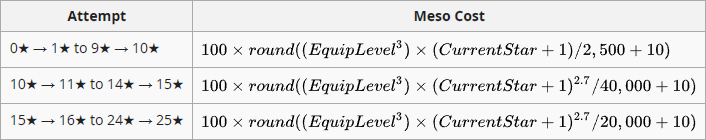

In [ ]:
def SimulateToStar(RatesArray, FailureArray, SafeGuardArray, StartStar, EndStar, ItemLevel, CopyCost, DiscountEvent):
    CurrentStar = StartStar
    ChanceTime = 0
    BoomCount = 0
    MesoCost = 0

    while CurrentStar < EndStar:
        if CurrentStar < 10:
            MesoCost += (((lambda: 0, lambda: 100)[SafeGuardArray[CurrentStar]]() + (lambda: 100, lambda: 70)[DiscountEvent]()
                         ) * round((pow(ItemLevel, 3) * pow(CurrentStar + 1, 1)) / (2500) + 10))     
        elif CurrentStar < 15:
            MesoCost += (((lambda: 0, lambda: 100)[SafeGuardArray[CurrentStar]]() + (lambda: 100, lambda: 70)[DiscountEvent]()
                         ) * round((pow(ItemLevel, 3) * pow(CurrentStar + 1, 2.7)) / (40000) + 10))
        else:
            MesoCost += (((lambda: 0, lambda: 100)[SafeGuardArray[CurrentStar]]() + (lambda: 100, lambda: 70)[DiscountEvent]()
                         ) * round((pow(ItemLevel, 3) * pow(CurrentStar + 1, 2.7)) / (20000) + 10))
                        # ((0 if not safeguarded OR 100 if safeguarded) + (100 if no event discount OR 70 if event discount))
                        # TIMES Round(((EquipLevel^3)*(CurrentStar+1)^2.7)/(20000)+10)
            
        # Baseprice is increased by 100 if SafeGuardArray at the CurrentStar index is True
        # The BasePrice is then either 100 or 70 depending on if DiscountEvent is True
        # Then multiplied by the given formula above.
        
        if ChanceTime == 2:
            ChanceTime = 0
            CurrentStar += 1
            # If two consecutive failures happen, go up a star and reset ChanceTime count
        elif random.random() <= RatesArray[CurrentStar]:
            ChanceTime = 0
            CurrentStar += 1
            # Else if we sucessfully hit the enchancment, go up a star and reset ChanceTime count
        else:
            # Else if we fail the enchancement 
            if random.random() <= FailureArray[CurrentStar][0]:
                ChanceTime = 0
                # If we hit the stay probability, reset ChanceTime count
            elif random.random() <= FailureArray[CurrentStar][1]:
                ChanceTime += 1
                CurrentStar -= 1
                # Else if we hit the drop probability, drop a star and increment ChanceTime count
            else:
                ChanceTime = 0
                MesoCost += CopyCost
                BoomCount += 1
                CurrentStar = 12
                # Else destroy the item, resetting it to 12 and adding the "CopyCost" to the total "MesoCost"
    return [MesoCost, BoomCount]

Now that we've created a proper enchancing simulation function accounting for the many possible variables, the Monte Carlo method can be used to calculate the expected value of the gear enhancement system in Maplestory. 

Our expected value in this case will be a measure of the average outcome over a large number of trials. In this case, trials would involve simulating the enhancement process with randomly generated success and failure rates, considering the cost of each attempt and the impact of events such as "Chance Time" and "Safeguard".

By repeating this process a large number of times, the Monte Carlo method can estimate the expected cost of enhancing an item from one level to another and the expected outcome, such as the likelihood of success, failure, or destruction. This information can be used to make informed decisions about the gear enhancement process and optimize your use of Meso.

Lastly, I created a function that will run an abritrary number of simulations, from which, that output can be used to generate a statistical overview, and histograms representing the simulated data.

Average Booms: 9.664
Median Booms:  7.0
Average Meso Cost: 16,050,082,330
Median Meso Cost : 12,025,937,000
Your 5 best trials:
[[604703000, 0], [803780400, 0], [873679200, 0], [942080400, 0], [950938700, 1]]
Your 5 worst trials:
[[116605226500, 71], [112074856800, 66], [93255453700, 46], [88839162400, 66], [78068823700, 62]]


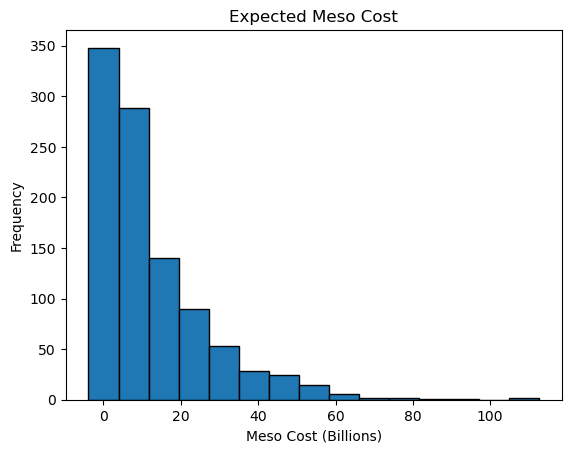

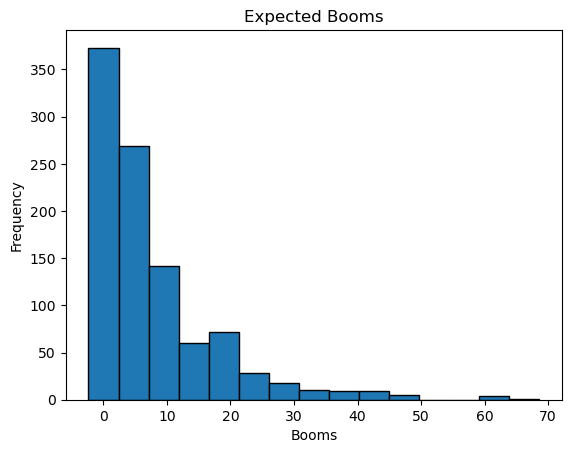

In [1]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import statistics

SuccessRates = [0.95, 0.9, 0.85, 0.85, 0.80, 0.75, 0.70, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.3, 0.3, 0.3, 0.3,
             0.3, 0.3, 0.3, 0.03, 0.02, 0.01]
FailureRates = [[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0],
                [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0],
                [1, 0, 0], [0, 1, 0], [0, 0.99, 0.01], [0, 0.98, 0.02], [0, 0.98, 0.02],
                [0.97, 0, 0.03], [0, 0.97, 0.03], [0, 0.97, 0.03], [0, 0.96, 0.04], [0, 0.96, 0.04],
                [0.90, 0, 0.1], [0, 0.9, 0.1], [0, 0.8, 0.2], [0, 0.7, 0.30], [0, 0.6, 0.4]]

StarCatchArray = [False for i in range(25)]
SafeGuardArray = [False for i in range(25)]


def EnhancedRates(BaseRatesArray, StarCatchBooleanArray, FiveTenFifteen):
    for i in range(len(StarCatchBooleanArray)):
        if StarCatchBooleanArray[i] == True:
            BaseRatesArray[i] *= 1.05
    if FiveTenFifteen:
        BaseRatesArray[5] = 1
        BaseRatesArray[10] = 1
        BaseRatesArray[15] = 1
    return BaseRatesArray


def NoBoom(FailureRatesArray, SafeGuardBooleanArray):
    for i in range(len(SafeGuardBooleanArray)):
        if SafeGuardBooleanArray[i] == True:
            if FailureRatesArray[i][0] == 0:
                FailureRatesArray[i][1] = 1
                FailureRatesArray[i][2] = 0
            else:
                FailureRatesArray[i][0] = 1
                FailureRatesArray[i][2] = 0
    return FailureRatesArray

def SimulateToStar(RatesArray, FailureArray, SafeGuardArray, StartStar, EndStar, ItemLevel, CopyCost, DiscountEvent):
    CurrentStar = StartStar
    ChanceTime = 0
    BoomCount = 0
    MesoCost = 0

    while CurrentStar < EndStar:
        if CurrentStar < 10:
            MesoCost += (((lambda: 0, lambda: 100)[SafeGuardArray[CurrentStar]]() + (lambda: 100, lambda: 70)[DiscountEvent]()
                         ) * round((pow(ItemLevel, 3) * pow(CurrentStar + 1, 1)) / (2500) + 10))     
        elif CurrentStar < 15:
            MesoCost += (((lambda: 0, lambda: 100)[SafeGuardArray[CurrentStar]]() + (lambda: 100, lambda: 70)[DiscountEvent]()
                         ) * round((pow(ItemLevel, 3) * pow(CurrentStar + 1, 2.7)) / (40000) + 10))
        else:
            MesoCost += (((lambda: 0, lambda: 100)[SafeGuardArray[CurrentStar]]() + (lambda: 100, lambda: 70)[DiscountEvent]()
                         ) * round((pow(ItemLevel, 3) * pow(CurrentStar + 1, 2.7)) / (20000) + 10))
        if ChanceTime == 2:
            ChanceTime = 0
            CurrentStar += 1
        elif random.random() <= RatesArray[CurrentStar]:
            ChanceTime = 0
            CurrentStar += 1
        else:
            if random.random() <= FailureArray[CurrentStar][0]:
                ChanceTime = 0
            elif random.random() <= FailureArray[CurrentStar][1]:
                ChanceTime += 1
                CurrentStar -= 1
            else:
                ChanceTime = 0
                BoomCount += 1
                MesoCost += CopyCost
                CurrentStar = 12
    return [MesoCost, BoomCount]

def RunSimulations(RatesArray, FailureArray, SafeGuardArray, StartStar, EndStar, ItemLevel, CopyCost, DiscountEvent, Trials):
    SimulationsArray = []
    for i in range(Trials):
        Simulation = SimulateToStar(RatesArray, FailureArray, SafeGuardArray, StartStar, EndStar, ItemLevel, CopyCost, DiscountEvent)
        SimulationsArray.append([Simulation[0],Simulation[1]])
    return SimulationsArray

#------------------------------------------------------

def PlotMesoCostSimulation(SimulationArray):
    OurSimulation = list(zip(*SimulationArray))

    costs = list(map(lambda value: round(value / 1000000000, 1), OurSimulation[0]))
    hist, bins = np.histogram(costs, bins=15, range=(0, max(costs)))
    plt.bar(bins[:-1], hist, width=bins[1]-bins[0], edgecolor='black')

    plt.xlabel('Meso Cost (Billions)')
    plt.ylabel('Frequency')
    plt.title('Expected Meso Cost')

    plt.show()
    
def PlotBoomCountSimulation(SimulationArray):
    OurSimulation = list(zip(*SimulationArray))
    
    hist, bins = np.histogram(OurSimulation[1], bins=15, range=(0, max(OurSimulation[1])))
    plt.bar(bins[:-1], hist, width=bins[1]-bins[0], edgecolor='black')

    plt.xlabel('Booms')
    plt.ylabel('Frequency')
    plt.title('Expected Booms')

    plt.show()
    
def SimulationStatistics(SimulationArray):
    OurSimulation = list(zip(*SimulationArray))
    print('Average Booms: '+str(statistics.mean(OurSimulation[1])))
    print('Median Booms:  '+str(statistics.median(OurSimulation[1])))
    print('Average Meso Cost: '+f"{round(statistics.mean(OurSimulation[0])):,}")
    print('Median Meso Cost : '+f"{round(statistics.median(OurSimulation[0])):,}")
    print('Your 5 best trials:')
    print(sorted(SimulationArray)[:5])
    print('Your 5 worst trials:')
    print((sorted(SimulationArray)[:-6:-1]))

# ---------------------------------------

for i in range(17, 22):
    StarCatchArray[i] = True

for i in range(12, 17):
    SafeGuardArray[i] = False

OriginalSimulation = RunSimulations(EnhancedRates(SuccessRates, StarCatchArray, FiveTenFifteen=False), NoBoom(FailureRates, SafeGuardArray), 
                   SafeGuardArray, 12, 22, ItemLevel=150, CopyCost=0, DiscountEvent=False, Trials=1000)

#-----------------------------------------

SimulationStatistics(OriginalSimulation)
PlotMesoCostSimulation(OriginalSimulation)
PlotBoomCountSimulation(OriginalSimulation)

# Problem 2

Items in maplestory also have another enhancing system called potentials.

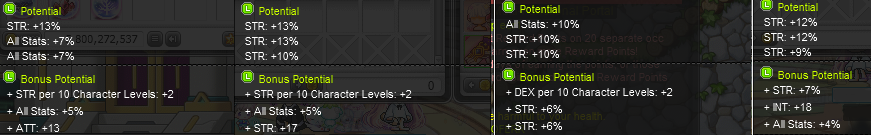

The "potentials" of an item in the game are subject to random variation, which are randomly rolled by cubes. Each item has a "main potential" and a "bonus potential". The calculation of the main potential has traditionally involved the multiplication of three independent probabilities, which correspond to rolling a specific line such as STR or All Stat. On the other hand, bonus potentials have a broader range of available lines, which oftentimes only 2 out of 3 lines are needed to be considered desirable. As a result, estimating the costs of rolling bonus potentials to standard requirements is highly complex and impractical to perform manually.

Fortunately, the probability distribution of rolling specific lines is accessible online through a foreign version of the game's website. By importing these probabilities and corresponding lines into lists, we can use the built-in function random.choices() to simulate the process of rolling a cube. Subsequently, we can assign a "stat score" to each line, allowing players to input their preferred stat equivalencies and evaluate whether a given roll meets their standards.

Average Statscore: 103.925
Median Statscore:  102.0
Average Cubes Needed: 91
Median Cubes Needed: 60
Your 2 worst trials:
[(['All Stats: +5%', 'STR : +16', 'All Stats: +4%'], 97, 328), (['STR : +7%', 'STR : +5%', 'Defense: +7%'], 102.0, 315)]
Your 2 best rolls:
[(['STR : +7%', 'ATT: +12', 'STR : +7%'], 149.0, 39), (['STR : +7%', 'STR : +5%', 'All Stats: +4%'], 138.0, 69)]


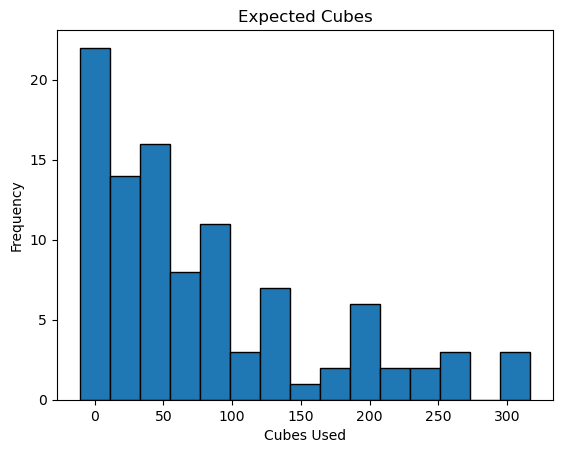

In [72]:
import os
import sys
import json
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statistics

root = os.path.abspath('.')
root += '/lineweights/'

def loadJson(name):
    full_path = root + name
    json_file = open(full_path, 'r')
    cfg = json.load(json_file)
    json_file.close()
    return cfg  

LegLines, LegProb = zip(*loadJson('LegendaryAccessory.json').items())
LegProb = list(map(float,LegProb))
UniqueLines, UniqueProb = zip(*loadJson('UniqueAccessory.json').items())
UniqueProb = list(map(float,UniqueProb))
#Loads lines and their probabilities into two seperate lists

def SimulateRoll(LegLinePool, LegProbability, UniqueLinePool, UniqueProbability, PrimeLineChance=0.05):
    LineOne = random.choices(LegLinePool, weights=LegProbability)
    #The first line is always "legendary". So a legendary line is chosen according to the weights.
    if random.random() <= PrimeLineChance: #The second line can be Legendary
        LineTwo = random.choices(LegLinePool, weights=LegProbability)
    else: #If not a unique line is chosen.
        LineTwo = random.choices(UniqueLinePool, weights=UniqueProbability)
    if random.random() <= PrimeLineChance: #The third line can be Legendary
        LineThree = random.choices(LegLinePool, weights=LegProbability)
    else: #If not a unique line is chosen.
        LineThree = random.choices(UniqueLinePool, weights=UniqueProbability)
    return LineOne+LineTwo+LineThree

def EvaluateRoll(currentroll, main_stat="STR", percent_value=8.5, all_stat_value=9, att_value=2.5, matt_value=0, level=270):
    results = []
    for roll in currentroll: #splits apart a "roll" as simulated in SimulateRoll()
        parts = roll.split(":") 
        stat = parts[0].strip()
        bonus = parts[1].strip() 
        #The line is split and stripped into two parts. One containing the stat it references.
        # and the second one containing the bonus it references
        
        if stat[0:3] == main_stat: #If the first 3 letters in line match the the "main_stat"
            if "%" in bonus: # if its a %stat line
                results.append(int(bonus[:-1]) * percent_value)
            elif "per 10" in stat: # if its a stat per 10 levels line
                results.append(int(bonus)*math.floor(level/10))
            else: # else its a flat bonus
                results.append(int(bonus))
        elif "All Stats" in stat: # if its a %all stat line
            results.append(int(bonus[:-1]) * all_stat_value)
        elif "ATT" in stat[0:3]: # if its an ATT line
            results.append(int(bonus) * att_value)  
        elif "Magic" in stat: # if its a Magic ATT line
            results.append(int(bonus) * matt_value)  
        else: # Worth 0 otherwise.
            results.append(0)
    return results

def RunSimulations(LegLinePool, LegProbability, UniqueLinePool, UniqueProbability, MinimumScore=91, Trials=1, PrimeLineChance=0.05, main_stat="STR", percent_value=8.5, all_stat_value=9, att_value=2.5, matt_value=0, level=270):
    if MinimumScore >= percent_value*19: # Prevent absurdly large inputs
        return 0
    
    SimulationArray = []
    for i in range(Trials): # Does x trials
        num_rolls = 0
        CurrentScore = 0

        while CurrentScore <= MinimumScore: # Roll until minimum criteria is met.
            CurrentRoll = SimulateRoll(LegLinePool, LegProbability, UniqueLinePool, UniqueProbability, PrimeLineChance)
            CurrentScore = sum(EvaluateRoll(CurrentRoll, main_stat, percent_value, all_stat_value, att_value, matt_value, level))
            num_rolls += 1
        SimulationArray.append((CurrentRoll, CurrentScore, num_rolls)) # Append results and continue to next trial if so.
    return SimulationArray

#------------------

def PlotCubeSimulation(SimulationArray):
    OurSimulation = list(zip(*SimulationArray))
    
    hist, bins = np.histogram(OurSimulation[2], bins=15, range=(0, max(OurSimulation[2])))
    #Create 15 bins to contain similiar data values, ranging from 0 to the maximum.
    plt.bar(bins[:-1], hist, width=bins[1]-bins[0], edgecolor='black')

    plt.xlabel('Cubes Used')
    plt.ylabel('Frequency')
    plt.title('Expected Cubes')

    plt.show()
    
def SimulationStatistics(SimulationArray):
    OurSimulation = list(zip(*SimulationArray))
    print('Average Statscore: '+str(statistics.mean(OurSimulation[1])))
    print('Median Statscore:  '+str(statistics.median(OurSimulation[1])))
    print('Average Cubes Needed: '+f"{round(statistics.mean(OurSimulation[2])):,}")
    print('Median Cubes Needed: '+f"{round(statistics.median(OurSimulation[2])):,}")
    print('Your 2 worst trials:')
    print(sorted(SimulationArray, key = lambda x: x[2])[:-3:-1])
    print('Your 2 best rolls:')
    print((sorted(SimulationArray, key = lambda x: x[1])[:-3:-1]))

#------------------------------



Simulation = RunSimulations(LegLines, LegProb, UniqueLines, UniqueProb, 92, 100)

SimulationStatistics(Simulation)

PlotCubeSimulation(Simulation)

